# Prepare

In [1]:
# general modules
import pandas as pd
import sqlite3 
import os
import pandas_profiling
import seaborn as sns
import sqlite3 as sql
import hashlib

In [2]:
# variables
INPUT_FOLDER = "input"
OUTPUT_FOLDER = "output"
DATA_FOLDER = "data"

xl_name = "global-superstore.xls" 
db_name = "superstore.db"

randon_state = 42

# Import

In [4]:
df_orders = pd.read_excel(os.path.join("..", INPUT_FOLDER, xl_name), sheet_name="Orders")
df_returns = pd.read_excel(os.path.join("..", INPUT_FOLDER, xl_name), sheet_name="Returns")
df_people = pd.read_excel(os.path.join("..", INPUT_FOLDER, xl_name), sheet_name="People")

### Column Inspection

In [5]:
df_orders.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'City', 'State', 'Country',
       'Postal Code', 'Market', 'Region', 'Product ID', 'Category',
       'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Shipping Cost', 'Order Priority'],
      dtype='object')

In [6]:
df_returns.columns

Index(['Returned', 'Order ID', 'Market'], dtype='object')

In [7]:
df_people.columns

Index(['Person', 'Region'], dtype='object')

In [8]:
df_people

,Person,Region
0,Anna Andreadi,Central
1,Chuck Magee,South
2,Kelly Williams,East
3,Matt Collister,West
4,Deborah Brumfield,Africa
5,Larry Hughes,AMEA
6,Nicole Hansen,Canada
7,Giulietta Dortch,Caribbean
8,Nora Preis,Central Asia
9,Jack Lebron,North


In [9]:
# seems to be not relevant at all

### Integration

In [10]:
raw_df = df_orders.merge(
    df_returns[["Order ID", "Returned"]],
    on="Order ID",
    how="left",
)

In [11]:
raw_df.columns


Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'City', 'State', 'Country',
       'Postal Code', 'Market', 'Region', 'Product ID', 'Category',
       'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Shipping Cost', 'Order Priority', 'Returned'],
      dtype='object')

In [12]:
# remove obviously useless columns
raw_df.drop(columns="Row ID", inplace=True)
raw_df.drop(columns="Order ID", inplace=True)

In [13]:
# anonymize customer name
raw_df["Customer Name"] = raw_df.apply(lambda x: hashlib.md5(x["Customer Name"].encode()).hexdigest(), axis=1)

# Store

In [15]:
conn = sql.connect(os.path.join("..", DATA_FOLDER, db_name))
raw_df.to_sql('superstore', conn, if_exists='replace')

C:\Users\Marc\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\generic.py:2779: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


 
**_--------- notebook hier aufsplitten ----------_**
 


In [16]:
# machine learning modules
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelBinarizer

import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, Ridge, Lasso

### Train-Test-Split

In [17]:
df_train, df_test = train_test_split(raw_df, random_state = randon_state)

In [18]:
print(df_train.shape)
print(df_test.shape)

(38471, 23)
(12824, 23)


# Inspect

In [56]:
df_train.head()

,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,...,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,Returned,ship_delay
27507,2012-12-27,2012-12-31,Standard Class,SP-20860,a7d03c30d416fc5f7d695b495884fdd7,Corporate,Murfreesboro,Tennessee,United States,37130.0,...,Accessories,SanDisk Ultra 16 GB MicroSDHC Class 10 Memory ...,72.744,7,0.2,-12.7302,6.720,Medium,NaN,4
35511,2014-12-25,2015-01-01,Standard Class,JD-15895,1b2850c124acd1bc24237b4b5228b65e,Corporate,Oosterhout,North Brabant,Netherlands,NaN,...,Labels,"Smead File Folder Labels, Adjustable",23.730,7,0.5,-21.0000,3.430,Low,NaN,7
9172,2012-05-08,2012-05-11,Second Class,AB-10600,6acab08bb2b385c8569adfd24730ee01,Corporate,Phnom Penh,Phnom Penh,Cambodia,NaN,...,Bookcases,"Dania Corner Shelving, Pine",617.100,5,0.0,172.6500,36.380,Medium,NaN,3
31366,2011-06-30,2011-07-02,Second Class,GH-14410,1528a0a296f3ecf500753855ea9a21a5,Home Office,Lima,Lima (city),Peru,NaN,...,Chairs,"Hon Bag Chairs, Red",54.180,3,0.4,-32.5200,4.919,Medium,Yes,2
24465,2013-06-23,2013-06-26,First Class,KW-16435,648a7c6f93ee0f453ee1378466a84ff8,Consumer,London,England,United Kingdom,NaN,...,Storage,"Fellowes Box, Wire Frame",50.625,3,0.1,20.2050,8.570,Medium,NaN,3


In [57]:
df_train.columns

Index(['Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name',
       'Segment', 'City', 'State', 'Country', 'Postal Code', 'Market',
       'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name',
       'Sales', 'Quantity', 'Discount', 'Profit', 'Shipping Cost',
       'Order Priority', 'Returned', 'ship_delay'],
      dtype='object')

### Target Column

Time between order and shipment in days

In [58]:
df_train['ship_delay'] = df_train.apply(lambda x: (x["Ship Date"]-x['Order Date']).days, axis=1)

<ipython-input-58-7ec150f686c2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['ship_delay'] = df_train.apply(lambda x: (x["Ship Date"]-x['Order Date']).days, axis=1)


In [59]:
df_train[["Order Date", "Ship Date", "ship_delay"]].head()

,Order Date,Ship Date,ship_delay
27507,2012-12-27,2012-12-31,4
35511,2014-12-25,2015-01-01,7
9172,2012-05-08,2012-05-11,3
31366,2011-06-30,2011-07-02,2
24465,2013-06-23,2013-06-26,3


<AxesSubplot:>

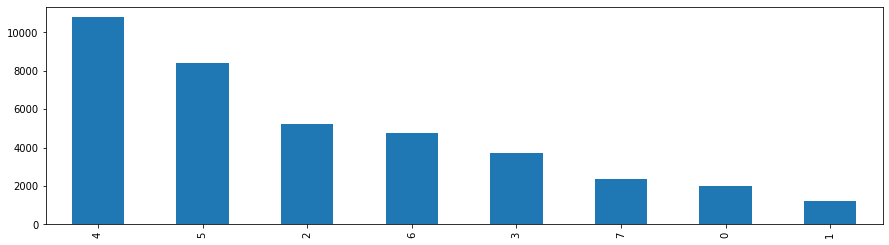

In [63]:
df_train["ship_delay"].value_counts().plot.bar()

### Profiling

In [61]:
profile = df_train.profile_report(title='Pandas Profiling Report')

In [62]:
profile.to_file(output_file=os.path.join("..", OUTPUT_FOLDER, "data_profile.html"))

Summarize dataset:   0%|          | 0/38 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Missings

In [23]:
df_train.isnull().sum()

Order Date            0
Ship Date             0
Ship Mode             0
Customer ID           0
Customer Name         0
Segment               0
City                  0
State                 0
Country               0
Postal Code       30915
Market                0
Region                0
Product ID            0
Category              0
Sub-Category          0
Product Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping Cost         0
Order Priority        0
Returned          36159
dtype: int64

Postal Code ==> useless

### Columnwise Inspection

#### Ship Date, Order Date

<AxesSubplot:xlabel='Count', ylabel='Order Date'>

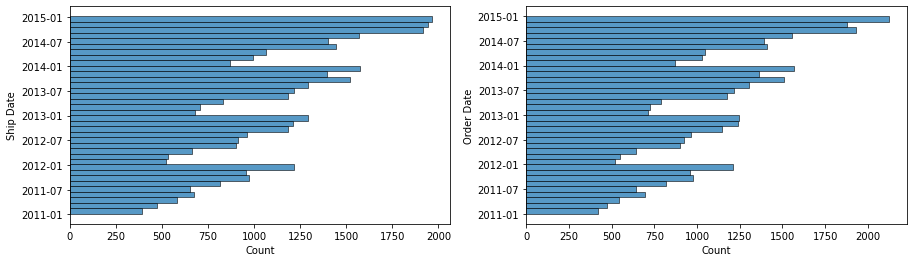

In [24]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [15, 4]
f, axes = plt.subplots(1, 2)

sns.histplot(data=df_train, y="Ship Date", ax=axes[0])
sns.histplot(data=df_train, y="Order Date", ax=axes[1])

#### Ship Mode

In [ ]:
df_train["Ship Mode"].value_counts()

* Predestined for OneHotEncoder

#### Customer ID, Customer Name

In [67]:
print("Unique values:", len(set(df_train["Customer ID"])))
print("Total values:", len(df_train["Customer ID"]))

Unique values: 1587
Total values: 38471


In [66]:
print("Unique values:", len(set(df_train["Customer Name"])))
print("Total values:", len(df_train["Customer Name"]))

Unique values: 795
Total values: 38471


* not useless at all... classification?

* customer may have nothing to do with the shipment delay (cannot be caused by the customer)

#### Segment

In [65]:
df_train["Segment"].value_counts()

Consumer       20019
Corporate      11471
Home Office     6981
Name: Segment, dtype: int64

=> OneHotEncoder

#### City, State, Country

In [68]:
print("Unique values City:", len(set(df_train["City"])))
print("Unique values State:", len(set(df_train["State"])))
print("Total values:", len(df_train["State"]))

Unique values City: 3475
Unique values State: 1072
Total values: 38471


In [69]:
df_train["Country"].value_counts()

United States        7556
Australia            2137
France               2114
Mexico               2012
Germany              1570
                     ... 
Equatorial Guinea       2
Chad                    1
Tajikistan              1
Burundi                 1
South Sudan             1
Name: Country, Length: 147, dtype: int64

=> Too high cardinality

#### Postal Code

useless due to missing values

#### Market

<AxesSubplot:ylabel='Market'>

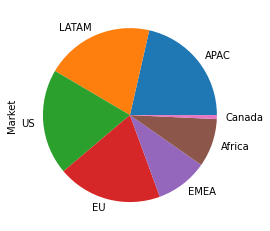

In [70]:
df_train["Market"].value_counts().plot.pie()

* looks interesting, OneHotEncoder; there may be differences in the regions

#### Region

<AxesSubplot:ylabel='Region'>

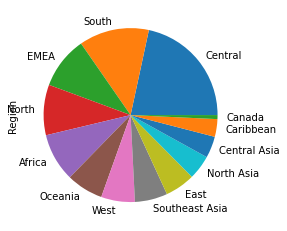

In [71]:
df_train["Region"].value_counts().plot.pie()

* almost the same as market, but more detailed

#### Product ID, Product Name

In [74]:
df_train["Product ID"]

27507    TEC-AC-10004227
35511    OFF-LA-10003699
9172     FUR-BO-10000112
31366    FUR-CH-10004338
24465    OFF-ST-10001646
              ...       
11284    FUR-BO-10001483
44732    OFF-LA-10002015
38158    OFF-LA-10004894
860      TEC-CO-10002009
15795    OFF-PA-10002725
Name: Product ID, Length: 38471, dtype: object

In [73]:
df_train["Product Name"]

27507    SanDisk Ultra 16 GB MicroSDHC Class 10 Memory ...
35511                 Smead File Folder Labels, Adjustable
9172                           Dania Corner Shelving, Pine
31366                                  Hon Bag Chairs, Red
24465                             Fellowes Box, Wire Frame
                               ...                        
11284                          Bush Corner Shelving, Metal
44732                       Hon Round Labels, Alphabetical
38158                    Hon Shipping Labels, Alphabetical
860                       Brother Wireless Fax, High-Speed
15795                     Eaton Cards & Envelopes, Premium
Name: Product Name, Length: 38471, dtype: object

* Obviously too detailed

#### Sales, Discount, Profit

<AxesSubplot:xlabel='Sales', ylabel='Count'>

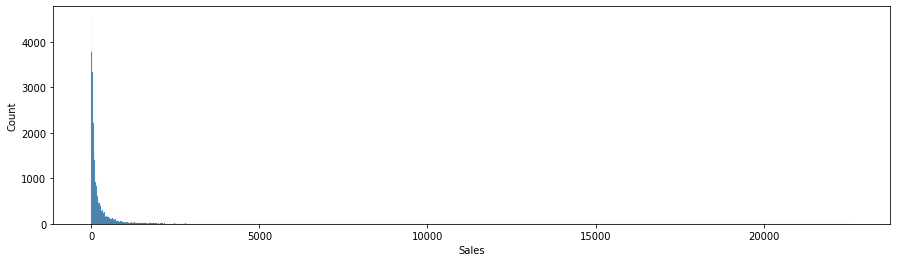

In [79]:
sns.histplot(data=df_train, x="Sales")

<AxesSubplot:xlabel='Sales', ylabel='Count'>

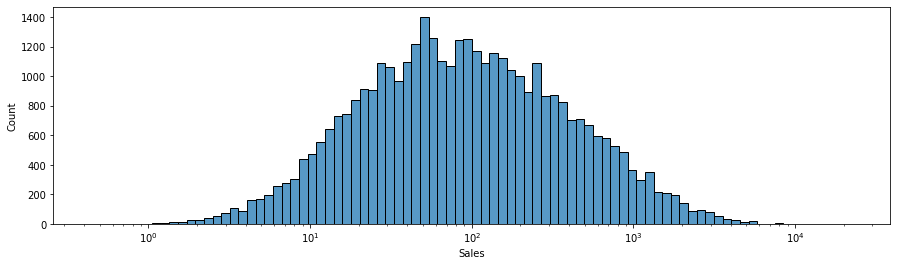

In [78]:
sns.histplot(data=df_train, x="Sales", log_scale=True)

In [82]:
df_train["Profit"].min()

-4088.3759999999997

In [83]:
df_train["Profit"].max()

8399.975999999999

[None]

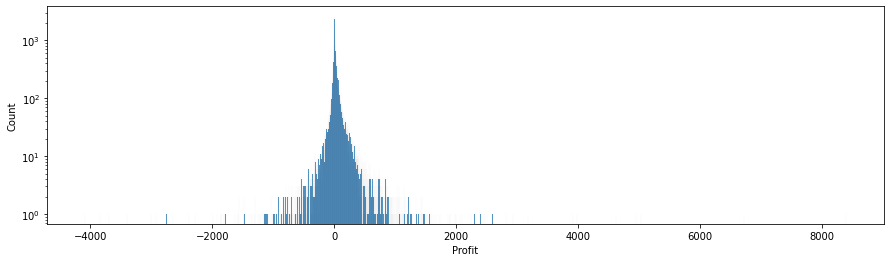

In [95]:
sns.histplot(df_train["Profit"]).set(yscale="log")

In [ ]:
# select potentially useful columns
useful_columns = [""]
df_inspect = df_train[useful_columns]

In [ ]:
#df_inspect.reset_index(drop=True, inplace=True)


In [ ]:
#df_inspect.loc[:,""] = LabelBinarizer().fit_transform(df_inspect["flirtInterests_date"])

In [ ]:
#sns.pairplot(data=df_inspect)

In [ ]:
#sns.heatmap(df_inspect.corr())

In [ ]:
#model = smf.ols(formula="target ~ a + b + c", data=df_inspect)
#results = model.fit()
#print(results.summary())